In [3]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [4]:
import os
import sys
import numpy as np
import pandas as ps

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset 


from l5kit.geometry import transform_points
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv
from l5kit.visualization import draw_trajectory

from utils import traj_geometry_from_item

sys.path.append("..")

import matplotlib.pyplot as plt

%matplotlib inline

from src.batteries import t2d, load_checkpoint
from src.batteries.progress import tqdm
from src.models.genet import genet_normal
from src.models.resnets import resnet18
from src.models import ModelWithConfidence
from src.criterion import neg_multi_log_likelihood_batch

In [5]:
DATA_DIR = "../data"
os.environ["L5KIT_DATA_FOLDER"] = DATA_DIR

In [12]:
cfg = {
    "format_version": 4,
    "model_params": {
        "history_num_frames": 10,
        "history_step_size": 1,
        "history_delta_time": 0.1,
        "future_num_frames": 50,
        "future_step_size": 1,
        "future_delta_time": 0.1,
    },
    "raster_params": {
        "raster_size": [384, 384],
        "pixel_size": [0.5, 0.5],
        "ego_center": [0.25, 0.5],
        "map_type": "py_semantic",
        "satellite_map_key": "aerial_map/aerial_map.png",
        "semantic_map_key": "semantic_map/semantic_map.pb",
        "dataset_meta_key": "meta.json",
        "filter_agents_threshold": 0.5,
    },
    "train_data_loader": {
        "key": "scenes/train.zarr",
        "batch_size": 12,
        "shuffle": True,
        "num_workers": 4,
    },
}

history_n_frames = cfg["model_params"]["history_num_frames"]
future_n_frames = cfg["model_params"]["future_num_frames"]
n_trajectories = 3
# model = ModelWithConfidence(
#     backbone=genet_normal(
#         in_channels=3 + (history_n_frames + 1) * 2,
#         num_classes=2 * future_n_frames * n_trajectories + n_trajectories,
#     ),
#     future_num_frames=future_n_frames,
#     num_trajectories=n_trajectories,
# )
model = ModelWithConfidence(
    backbone=resnet18(
        pretrained=False,
        in_channels=3 + 2 * (history_n_frames + 1),
        num_classes=2 * future_n_frames * n_trajectories + n_trajectories,
    ),
    future_num_frames=future_n_frames,
    num_trajectories=n_trajectories,
).cuda()
load_checkpoint("../logs/resnet18_bigerimages/stage_0/best.pth", model)

<= Loaded model from '../logs/resnet18_bigerimages/stage_0/best.pth'
Stage: stage_0
Epoch: 1
Metrics:
{'train': {'loss': 16.331650656055654}, 'valid': {'loss': 16.331650656055654}}


In [13]:
model = model.eval()

In [14]:
dm = LocalDataManager(None)
rasterizer = build_rasterizer(cfg, dm)

valid_zarr = ChunkedDataset(dm.require("scenes/validate_chopped_100/validate.zarr")).open()
# test_mask = np.load(f"{DATA_DIR}/scenes/mask.npz")["arr_0"]

valid_dataset = AgentDataset(
    cfg, valid_zarr, rasterizer
)

In [89]:
TARGET_POINTS_COLOR = (255, 0, 0)
HISTORICAL_POINTS_COLOR = (255, 255, 0)
PREDICT_POINTS_COLOR = (128, 0, 128)


def visualize_trajectory(
    data, show=True, title="target_positions movement with draw_trajectory", mode=None
):
    with torch.no_grad():
        preds, conf = model(torch.from_numpy(data["image"]).unsqueeze(0).cuda())

    preds = preds.detach().cpu().numpy()[0]
    
    for _m in range(3):
        preds[_m, :, :] = transform_points(preds[_m, :, :], data["raster_from_agent"]) # - data["centroid"][:2]
    
    plt.figure(figsize=(13, 13))
    im = data["image"].transpose(1, 2, 0)
    im = rasterizer.to_rgb(im)

    positions_tgt = transform_points(
        data["target_positions"],
        data["raster_from_agent"]
    )
    draw_trajectory(
        on_image=im,
        positions=positions_tgt,
        rgb_color=TARGET_POINTS_COLOR,
        radius=1
    )
    
    if mode is None:
        for _mod in range(3):
            draw_trajectory(
                on_image=im,
                positions=preds[_mod],
                rgb_color=PREDICT_POINTS_COLOR,
                radius=1
            )
    else:
        draw_trajectory(
            on_image=im,
            positions=preds[mode],
            rgb_color=PREDICT_POINTS_COLOR,
            radius=1
        )
    
    positions_hst = transform_points(
        data["history_positions"],
        data["raster_from_agent"]
    )
    draw_trajectory(
        on_image=im,
        positions=positions_hst,
        rgb_color=HISTORICAL_POINTS_COLOR,
        radius=2
    )

    if show:
        plt.title(title)
        plt.imshow(im[::-1])
        plt.show()
    else:
        return im[::-1]

In [18]:
losses = ps.read_csv("findings/validation_subset_losses.csv")
losses = losses.sort_values("loss", ascending=False)
# losses = losses.sort_values("loss", ascending=True)

print(losses.shape)
start, size = 0, 20
losses.iloc[start:start + size]

(592216, 2)


,record,loss
243473,243473,11036.0270
243468,243468,10990.1670
243463,243463,10949.5310
243457,243457,10925.6180
243451,243451,10881.7460
243440,243440,10829.1720
243435,243435,10803.8730
243430,243430,10785.2640
243425,243425,10761.9210
243445,243445,10737.7810


In [13]:
# with torch.no_grad():
#     preds, conf = model(torch.from_numpy(sample["image"]).unsqueeze(0))

# preds = preds.detach().cpu().numpy()[0]
# preds.shape

In [14]:
# preds[0]

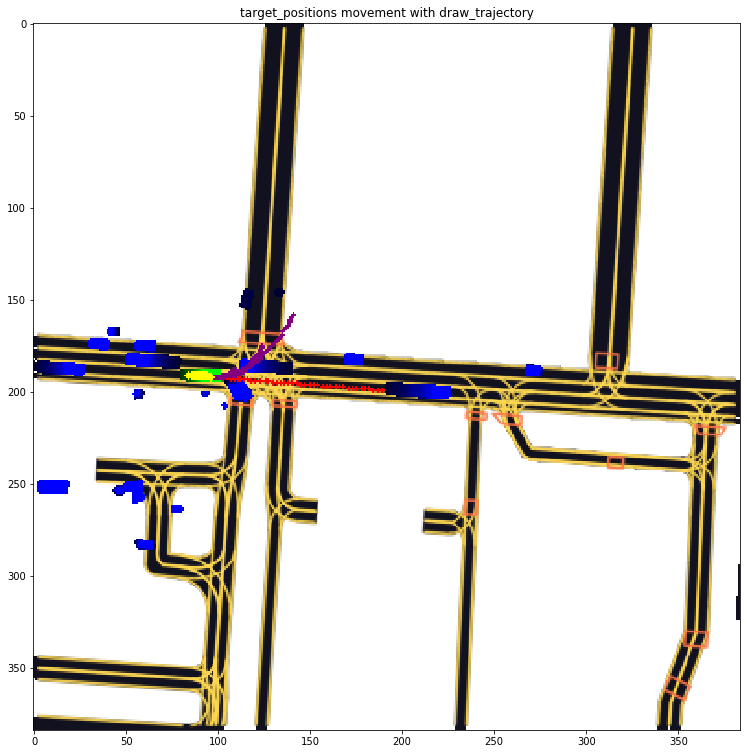

In [20]:
idx = 56770
sample = valid_dataset[idx]
visualize_trajectory(sample)

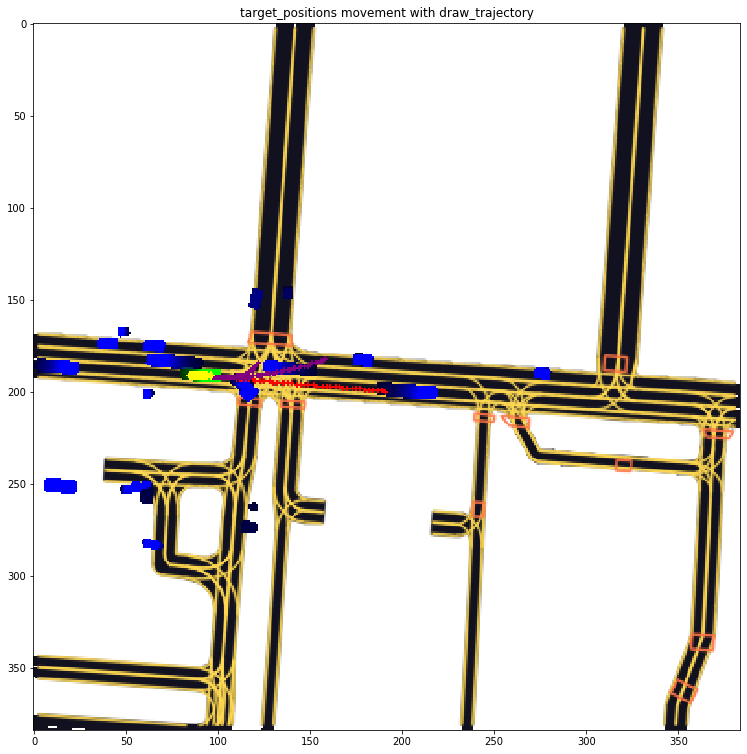

In [79]:
idx = 56748
sample = valid_dataset[idx]

# columns = 11
# rows = 3

# fig = plt.figure(figsize=(80, 20), facecolor="white")

# for i in range(11):
#     fig.add_subplot(rows, columns, i + 1)
#     plt.imshow(sample["image"][i])
#     plt.title(f"frame {i}")
    
# for i in range(11, 22):
#     fig.add_subplot(rows, columns, i + 1)
#     plt.imshow(sample["image"][i])
#     plt.title(f"frame {i - 11}")
    
# for i in range(22, 25):
#     fig.add_subplot(rows, columns, i + 1)
#     plt.imshow(sample["image"][i])

visualize_trajectory(sample)

In [23]:
test_dataset = Subset(
    valid_dataset,
    np.random.permutation(len(valid_dataset))[:10_000]
)
print(len(test_dataset))

test_loader = DataLoader(
    test_dataset, 
    batch_size=32,
    num_workers=20,
    shuffle=False,
)
print(len(test_loader))

10000
313


In [27]:
device = torch.device("cuda:0")
model = model.to(device)
model.eval()

# store information for evaluation
predictions = []
losses = []

with torch.no_grad(), tqdm(total=len(test_loader)) as progress:
    for batch in test_loader:
        images, targets, target_availabilities = t2d(
            (
                batch["image"],
                batch["target_positions"],
                batch["target_availabilities"],
            ),
            device,
        )

        preds, confidences = model(images)
        loss = neg_multi_log_likelihood_batch(
            targets, preds, confidences, target_availabilities,
            reduction="none"
        ) # (bs)
        losses.append(loss.detach().cpu().numpy())

        preds = preds.cpu().numpy().copy()
        world_from_agents = batch["world_from_agent"].numpy()
        centroids = batch["centroid"].numpy()
        for idx in range(len(preds)):
            for mode in range(n_trajectories):
                preds[idx, mode, :, :] = transform_points(preds[idx, mode, :, :], world_from_agents[idx]) - centroids[idx][:2]
        
        predictions.append(preds.copy())

        progress.update(1)

losses = np.concatenate(losses)

100%|████████████████████| 313/313 [01:46<00:00,  2.94it/s]


In [34]:
# from multiprocessing import Pool

# with Pool(5) as p:
#     print(p.map(f, [1, 2, 3]))

In [36]:
# from joblib import Parallel, delayed


# def is_small_fn(item):
#     return traj_geometry_from_item(item)[0] < 6


# is_small = Parallel(n_jobs=10)(
#     delayed(is_small_fn)(item)
#     for item in tqdm(test_dataset)
# )

In [37]:
is_small = list(map(lambda item: traj_geometry_from_item(item)[0] < 6, test_dataset))

# for idx in tqdm(range(losses.shape[0])):
#     item = test_dataset[idx]
#     size, _, _ = traj_geometry_from_item(item)
#     is_small.append(size < 6)

In [40]:
np.unique(is_small, return_counts=True)

(array([False,  True]), array([3251, 6749]))

In [41]:
is_small_arr = np.array(is_small, dtype=np.bool)

In [163]:
np.mean(losses[is_small_arr]), np.mean(losses[~is_small_arr])

(2.0624342, 21.81733)

In [54]:
np.median(losses[~is_small_arr]), losses[~is_small_arr].shape

(6.4047375, (3251, 1))

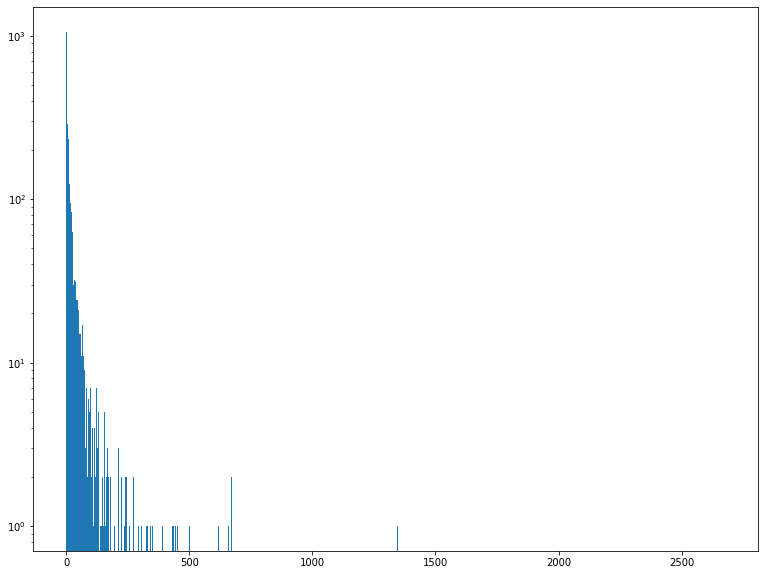

In [53]:
plt.figure(figsize=(13, 10))
plt.hist(losses[~is_small_arr], bins=1000, log=True);

In [63]:
bad_idxs = np.argsort(losses[:, 0])[::-1]
reindex = ~is_small_arr[bad_idxs]
bad_idxs[reindex]

array([1029, 6144, 2238, ..., 4269, 2239, 6417])

In [101]:
bad_idxs[reindex][10:20]

array([5965, 4729, 5977, 4828, 1635, 4837, 8900, 6024, 9699, 9929])

In [64]:
losses[1029], losses[6417]

(array([2677.3694], dtype=float32), array([0.00054264], dtype=float32))

In [134]:
def points_trajectory(
    data, show=True, title="target_positions movement with draw_trajectory", mode=None
):
    with torch.no_grad():
        images = torch.from_numpy(data["image"]).unsqueeze(0).cuda()
        targets = torch.from_numpy(data["target_positions"]).unsqueeze(0).cuda()
        target_availabilities = torch.from_numpy(data["target_availabilities"]).unsqueeze(0).cuda()
        
        preds, conf = model(images)
        loss = neg_multi_log_likelihood_batch(
            targets, preds, conf, target_availabilities, reduction="mean"
        ).item()
    

    preds = preds.detach().cpu().numpy()[0]
    conf = conf.detach().cpu().numpy()[0]
    
    colors = "rgb"
    
    for _m in range(3):
        preds[_m, :, :] = transform_points(preds[_m, :, :], data["raster_from_agent"]) # - data["centroid"][:2]
        plt.plot(preds[_m, :, 0], preds[_m, :, 1], colors[_m])
        plt.axis("square")
    plt.title(f"loss = {loss}")
    plt.show()
    
    print(conf)

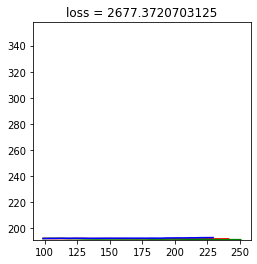

[0.4945196  0.26988965 0.23559079]


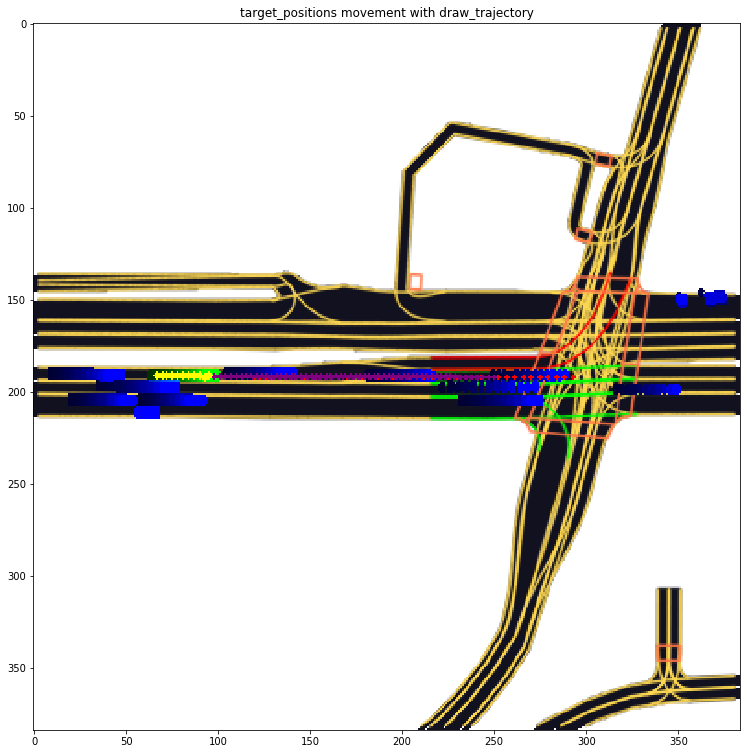

In [135]:
points_trajectory(test_dataset[1029])
visualize_trajectory(test_dataset[1029])

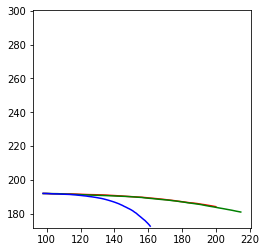

[0.52302307 0.39462987 0.08234706]


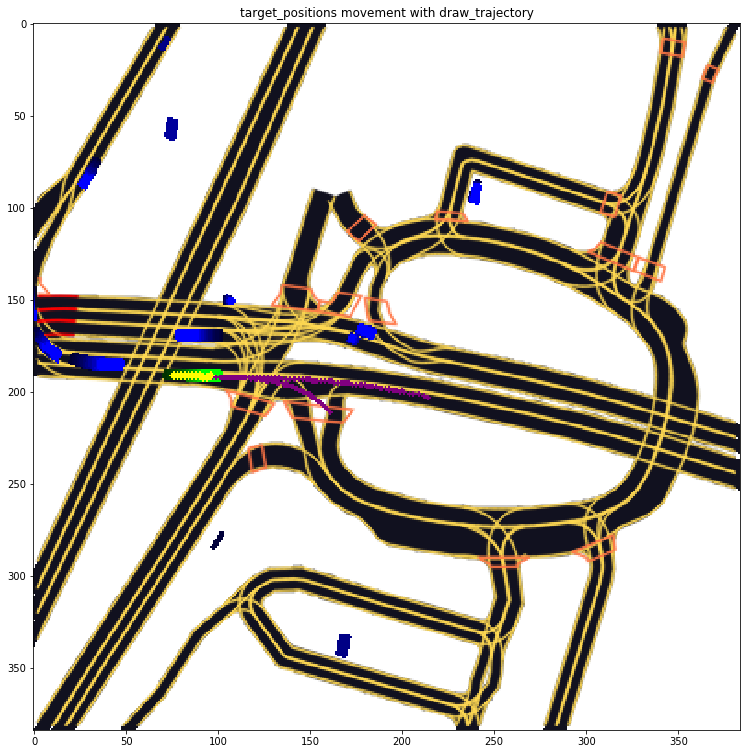

In [100]:
points_trajectory(test_dataset[6417])
visualize_trajectory(test_dataset[6417])

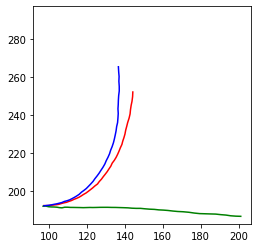

[0.09829475 0.73568326 0.16602191]


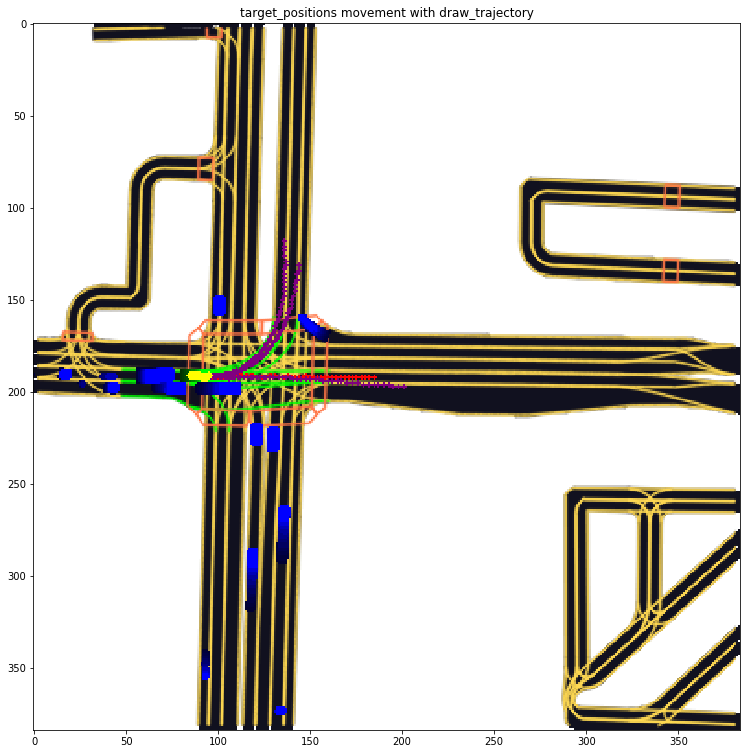

In [102]:
points_trajectory(test_dataset[4837])
visualize_trajectory(test_dataset[4837])

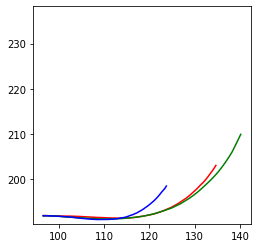

[0.4316562  0.41720316 0.15114069]


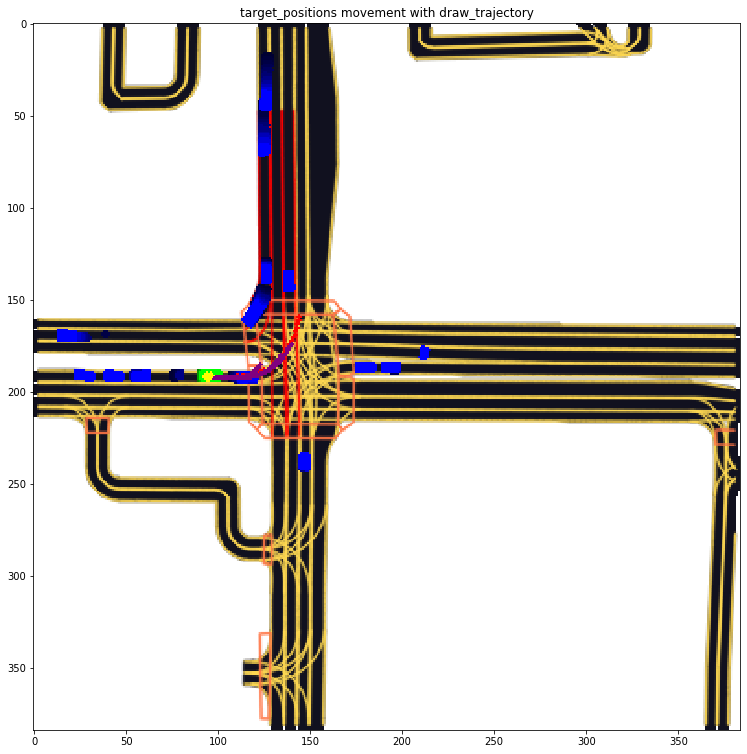

In [103]:
points_trajectory(test_dataset[9929])
visualize_trajectory(test_dataset[9929])

In [110]:
_losses = losses.copy()

clip_value = 40
_losses[_losses > clip_value] = clip_value

_losses.mean(), losses.mean()

(5.0764065, 8.48475)

In [125]:
tmp_losses = losses[~is_small_arr].copy()

tmp_losses[np.argsort(tmp_losses[:, 0])[::-1]][250]

array([56.85792], dtype=float32)

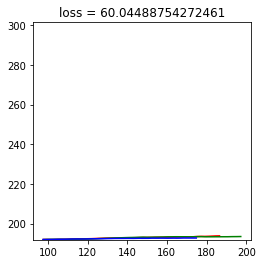

[0.45506167 0.3268609  0.21807742]


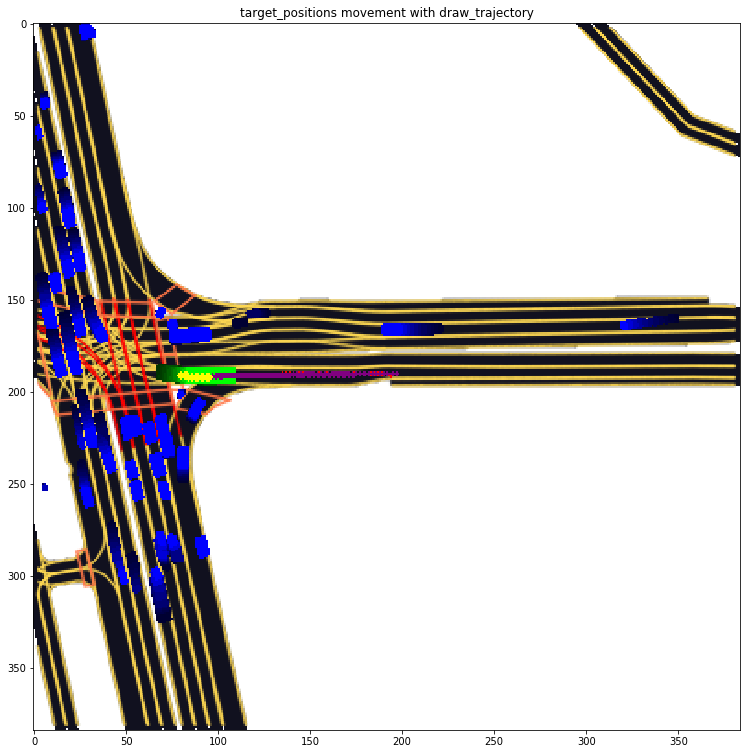

In [140]:
points_trajectory(test_dataset[bad_idxs[250]])
visualize_trajectory(test_dataset[bad_idxs[250]])

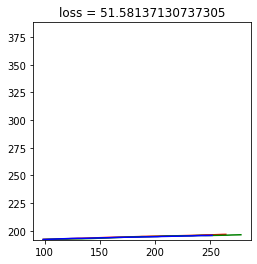

[0.4469923  0.21237388 0.34063384]


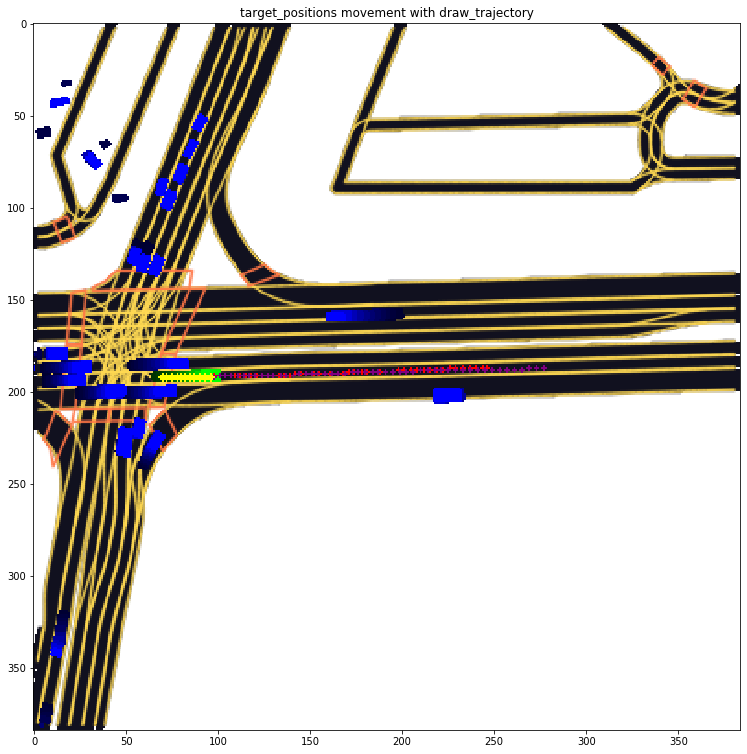

In [144]:
points_trajectory(test_dataset[bad_idxs[300]])
visualize_trajectory(test_dataset[bad_idxs[300]], mode=1)

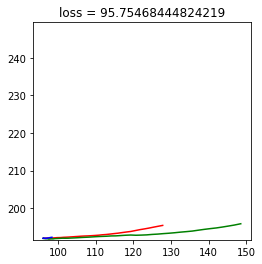

[0.1800408  0.21022949 0.6097297 ]


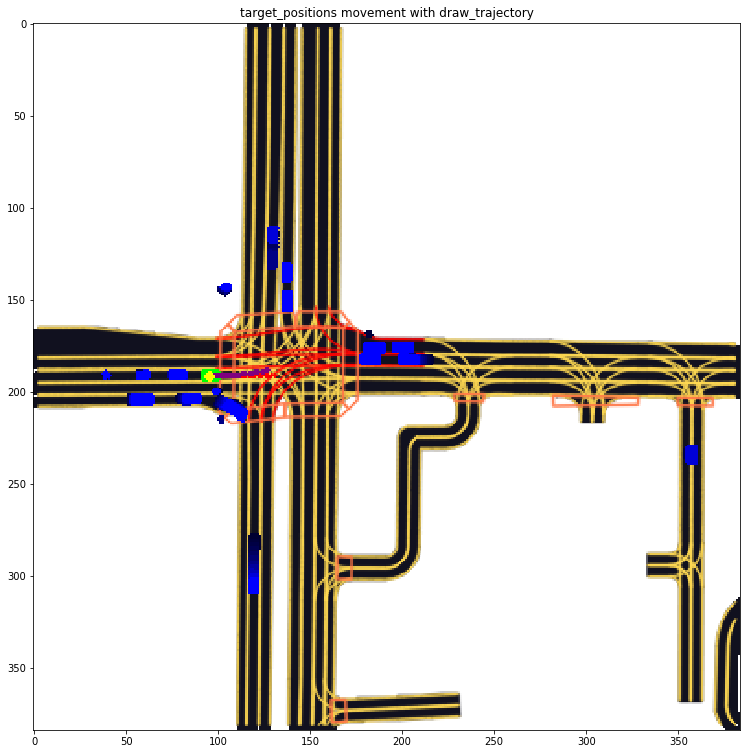

In [147]:
index = 150
points_trajectory(test_dataset[bad_idxs[index]])
visualize_trajectory(test_dataset[bad_idxs[index]], mode=0)

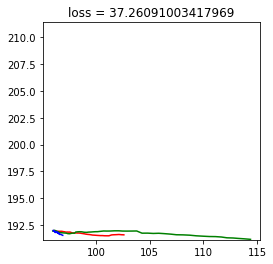

[0.15463836 0.04047311 0.80488855]


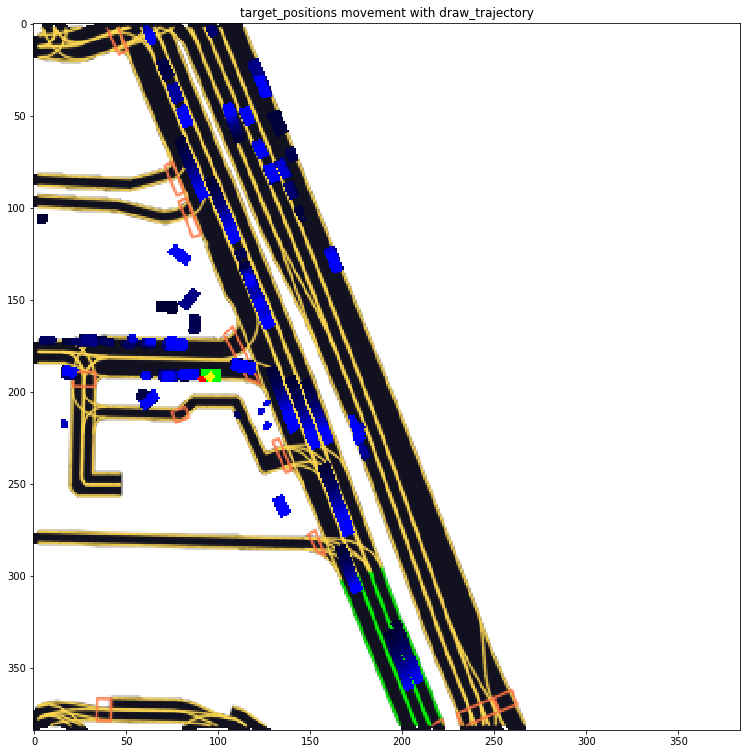

In [149]:
index = 450
points_trajectory(test_dataset[bad_idxs[index]])
visualize_trajectory(test_dataset[bad_idxs[index]], mode=2)

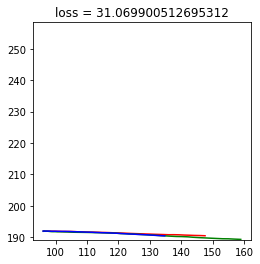

[0.4681968  0.24862598 0.28317723]


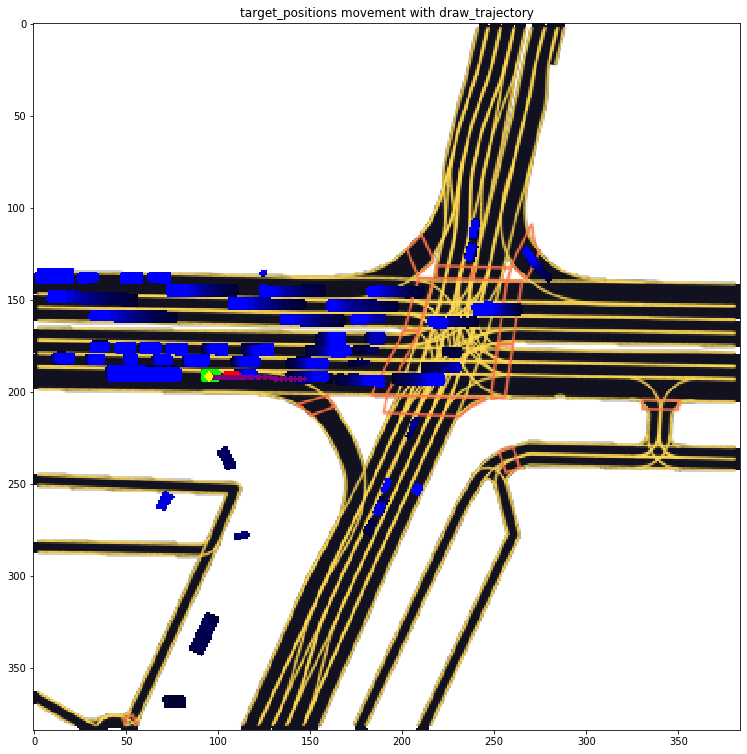

In [151]:
index = 550
points_trajectory(test_dataset[bad_idxs[index]])
visualize_trajectory(test_dataset[bad_idxs[index]], mode=0)

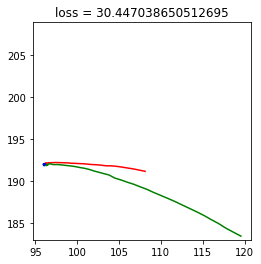

[0.01935658 0.00670607 0.97393733]


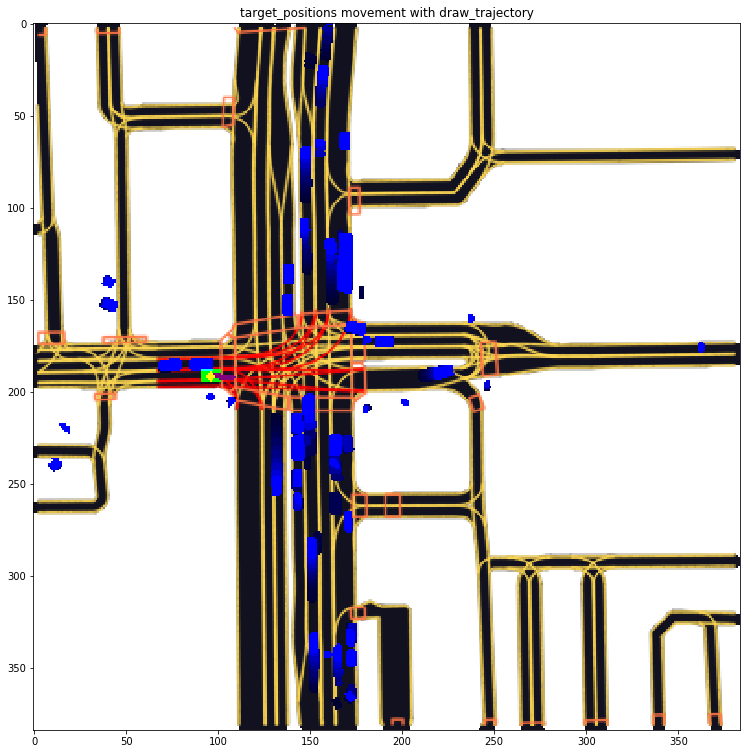

In [169]:
index = 560
points_trajectory(test_dataset[bad_idxs[index]])
visualize_trajectory(test_dataset[bad_idxs[index]], mode=0)

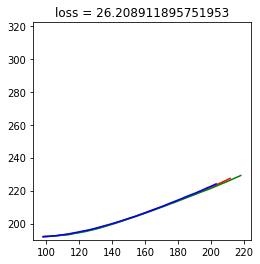

[0.5232441  0.28080007 0.19595584]


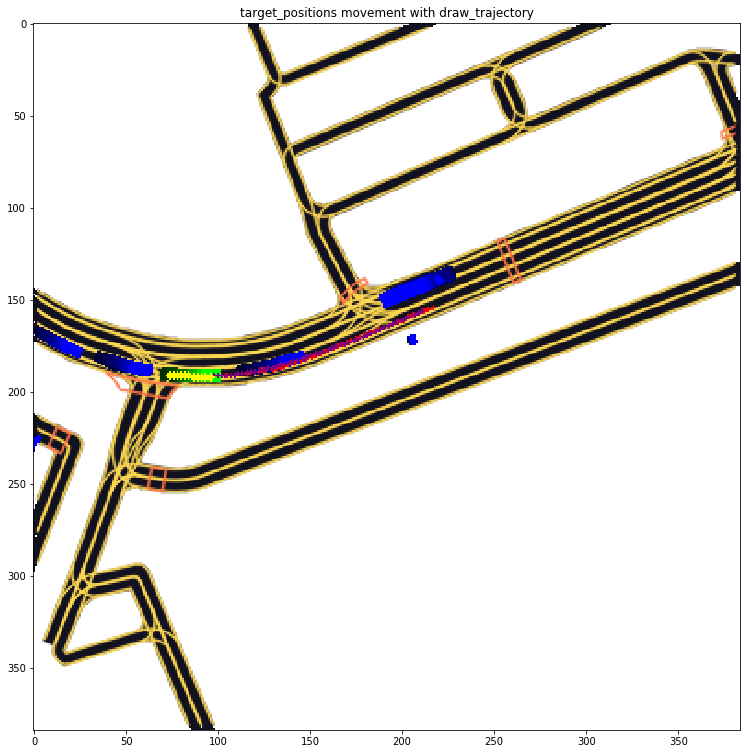

In [152]:
index = 650
points_trajectory(test_dataset[bad_idxs[index]])
visualize_trajectory(test_dataset[bad_idxs[index]], mode=0)

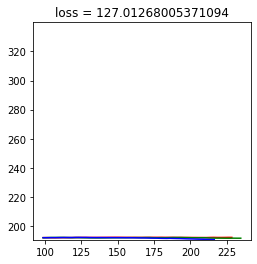

[0.49887967 0.37609178 0.12502861]


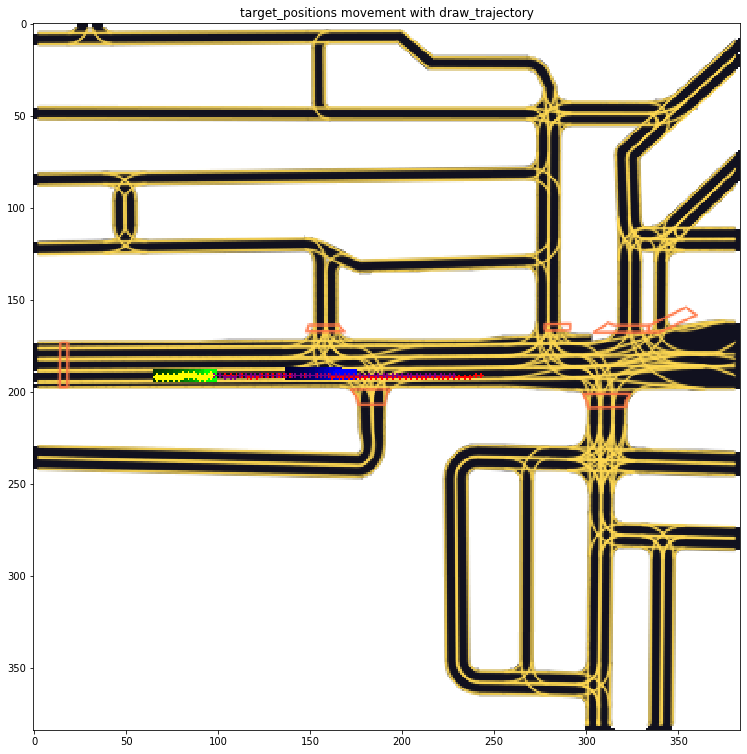

In [154]:
index = 100
points_trajectory(test_dataset[bad_idxs[index]])
visualize_trajectory(test_dataset[bad_idxs[index]], mode=0)

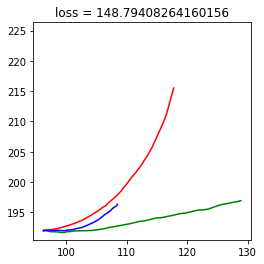

[0.3823441  0.20585655 0.41179943]


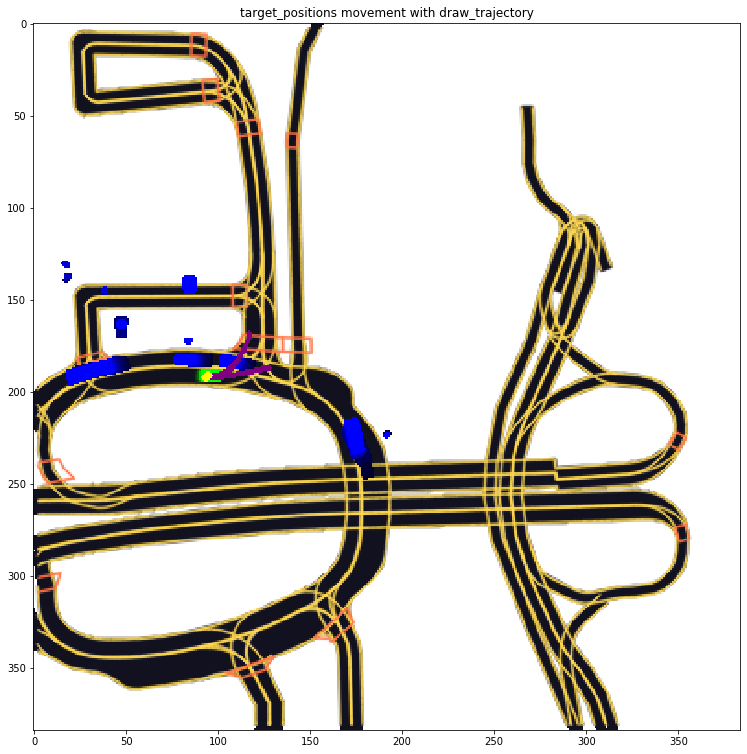

In [156]:
index = 80
points_trajectory(test_dataset[bad_idxs[index]])
visualize_trajectory(test_dataset[bad_idxs[index]])

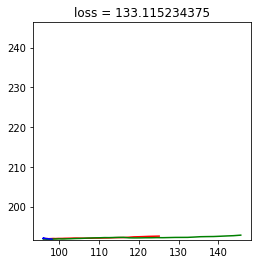

[0.09466483 0.06781589 0.83751935]


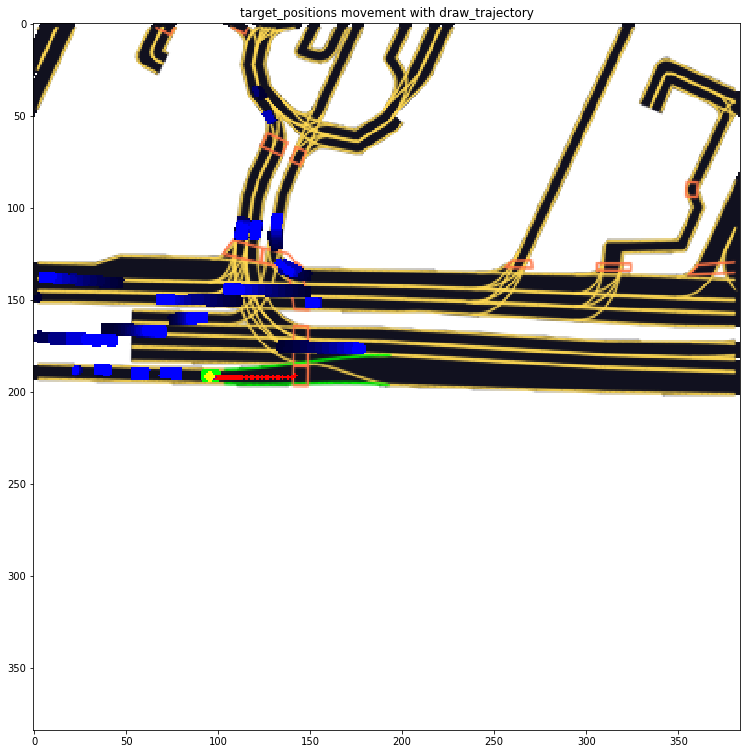

In [159]:
index = 90
points_trajectory(test_dataset[bad_idxs[index]])
visualize_trajectory(test_dataset[bad_idxs[index]], mode=2)

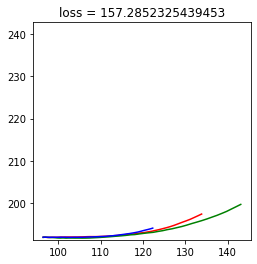

[0.45636395 0.29245156 0.25118443]


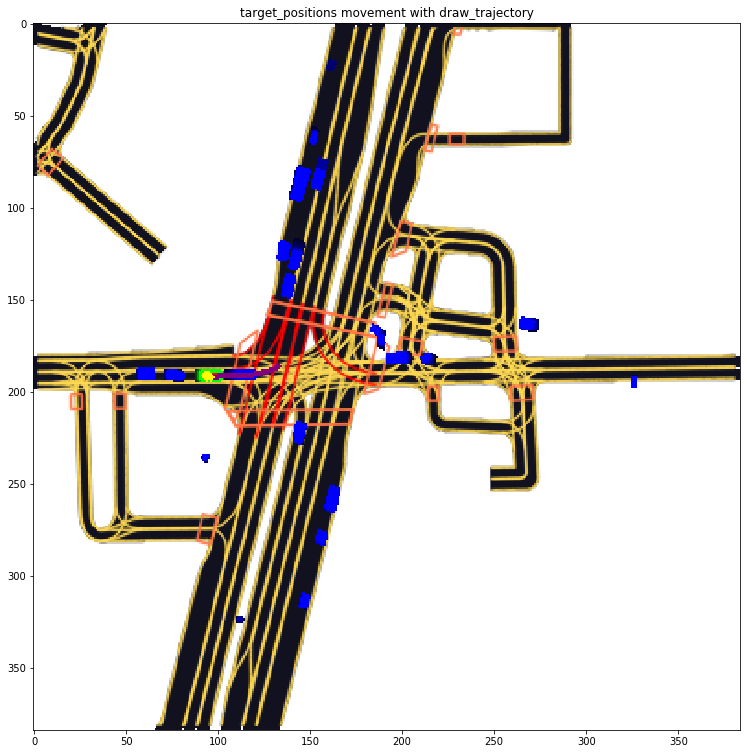

In [161]:
index = 70
points_trajectory(test_dataset[bad_idxs[index]])
visualize_trajectory(test_dataset[bad_idxs[index]], mode=0)